In [7]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [1]:
import pre_organize_xuwen as po

In [2]:
dimension = 32
skip_size = 8
skip_window = 1
num_skips = 2
iteration_train_vectors = 5000

num_layers = 2
size_layer = 256
learning_rate = 0.001
epoch = 10
batch = 30

In [9]:
string, data, label, vocab = po.read_data('train.csv',200)
label_encode = LabelEncoder().fit_transform(label)
dictionary, reverse_dictionary, vectors = po.generatevector(dimension, dimension, skip_size, skip_window, num_skips, iteration_train_vectors, string)

there are 200 total rows
data size:  14353
Creating Word2Vec model.


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Instructions for updating:
keep_dims is deprecated, use keepdims instead
epoch:  1000 , loss:  10.9858 , speed:  0.0023491382598876953
epoch:  2000 , loss:  10.2689 , speed:  0.009308338165283203
epoch:  3000 , loss:  0.0128828 , speed:  0.002440929412841797
epoch:  4000 , loss:  0.0246695 , speed:  0.0024280548095703125
epoch:  5000 , loss:  0.0259983 , speed:  0.002373933792114258


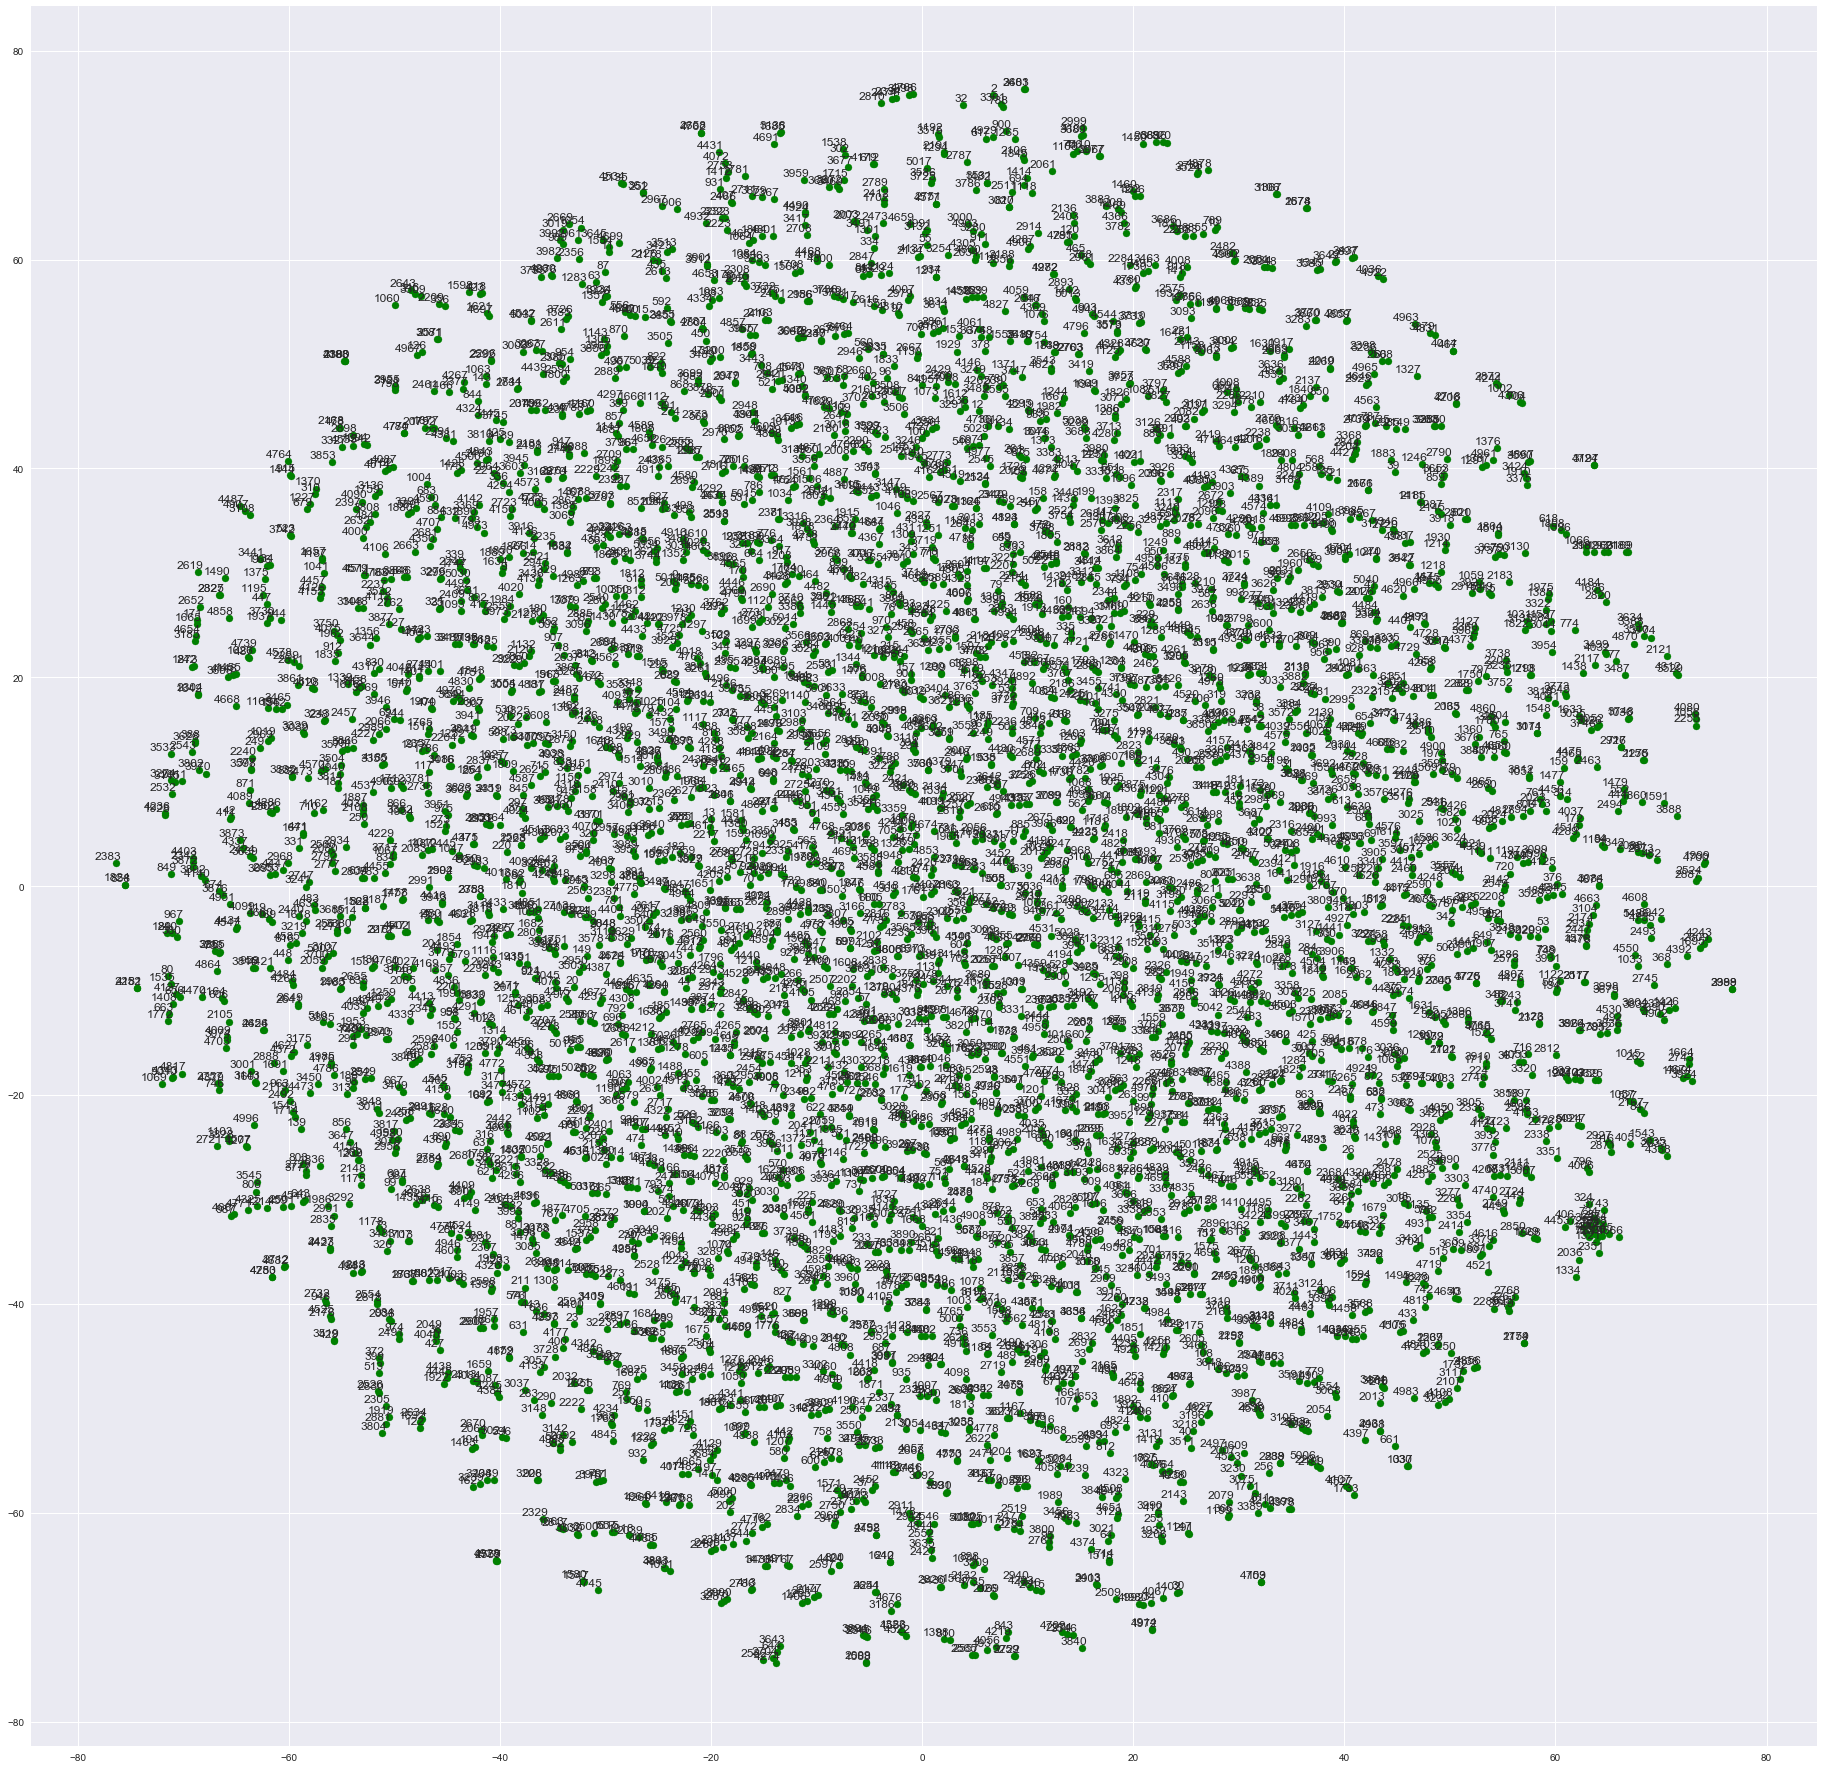

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
sns.set()

embed = TSNE(n_components = 2).fit_transform(vectors)
plt.figure(figsize = (32, 32))

for i, label in enumerate(reverse_dictionary):
    x, y = embed[i, :]
    plt.scatter(x, y, c = 'g')
    plt.annotate(label, xy = (x, y), xytext = (5, 2), textcoords = 'offset points', ha = 'right', va = 'bottom')

plt.show()


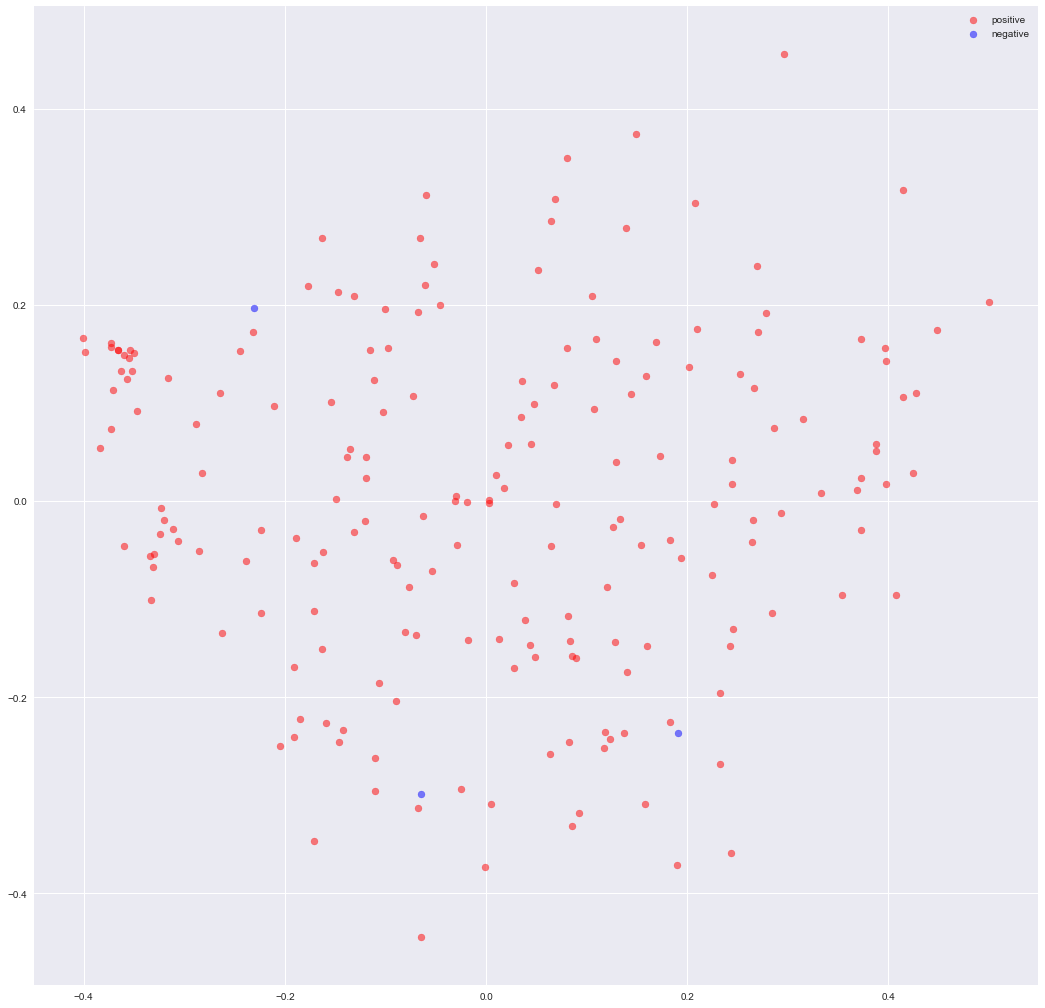

In [11]:
bagofword = np.zeros((len(data), len(vocab)))
for i in range(len(data)):
    for _, text in enumerate(data[i].split()):
        bagofword[i, vocab.index(text)] += 1.0
        
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer

bagofword = Normalizer().fit_transform(bagofword)
data_visual = PCA(n_components = 2).fit_transform(bagofword)
palette = ['r', 'b']
data_label = ['positive','negative']

plt.figure(figsize = (18, 18))
for no, _ in enumerate(np.unique(label_encode)):
    plt.scatter(data_visual[label_encode == no, 0], data_visual[label_encode == no, 1], c = palette[no], label = data_label[no], alpha = 0.5)
    
plt.legend()
plt.show()

In [14]:
dimension_input = len(vocab)
print('dimension size: ', str(dimension_input))
print('sentence size: ', len(data))

dimension size:  5043
sentence size:  200


In [12]:
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data, label_encode, test_size = 0.15)

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [16]:
import Model1 as md
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = md.Model1(num_layers, size_layer, dimension_input, np.unique(label_encode).shape[0], learning_rate)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.global_variables())

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



epoch:  1 , loss:  0.404646143317 , accuracy train:  0.919999992847 s / batch:  3.123075246810913
testing accuracy:  0.966667
             precision    recall  f1-score   support

   negative       0.97      1.00      0.98        29
   positive       0.00      0.00      0.00         1

avg / total       0.93      0.97      0.95        30



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1139: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


epoch:  2 , loss:  2.2758698225 , accuracy train:  0.973333323002 s / batch:  2.870996379852295
testing accuracy:  0.966667
             precision    recall  f1-score   support

   negative       0.97      1.00      0.98        29
   positive       0.00      0.00      0.00         1

avg / total       0.93      0.97      0.95        30

epoch:  3 , loss:  0.128320690244 , accuracy train:  0.966666650772 s / batch:  3.1322341918945313
testing accuracy:  0.933333
             precision    recall  f1-score   support

   negative       0.97      0.97      0.97        29
   positive       0.00      0.00      0.00         1

avg / total       0.93      0.93      0.93        30

epoch:  4 , loss:  0.114579865336 , accuracy train:  0.966666650772 s / batch:  3.60229697227478
testing accuracy:  0.933333
             precision    recall  f1-score   support

   negative       0.97      0.97      0.97        29
   positive       0.00      0.00      0.00         1

avg / total       0.93      0.93 

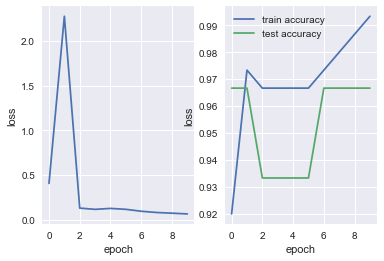

In [18]:
import time
import random
import collections

from sklearn import metrics

ACC_TRAIN, ACC_TEST, LOST = [], [], []
for i in range(epoch):
    total_cost = 0
    total_accuracy = 0
    last_time = time.time()
    
    for n in range(0, (len(X_train) // batch) * batch, batch):
        batch_x = np.zeros((dimension, batch, dimension_input))
        batch_y = np.zeros((batch, np.unique(Y_train).shape[0]))
        for k in range(batch):
            emb_data = np.zeros((dimension, dimension_input), dtype = np.float32)
            for _, text in enumerate(X_train[n + k].split()):
                # if the word got in the vocab
                try:
                    emb_data[:, vocab.index(text)] += vectors[dictionary[text], :]
                # if not, skip
                except:
                    continue

            batch_y[k, int(Y_train[n + k])] = 1.0
            batch_x[:, k, :] = emb_data[:, :]
            
        loss, _ = sess.run([model.cost, model.optimizer], feed_dict = {model.X : batch_x, model.Y : batch_y})
        total_accuracy += sess.run(model.accuracy, feed_dict = {model.X : batch_x, model.Y : batch_y})
        total_cost += loss
        
    total_cost /= (len(X_train) // batch)
    total_accuracy /= (len(X_train) // batch)
    times = (time.time() - last_time) / (len(X_train) // batch)
        
    ACC_TRAIN.append(total_accuracy)
    LOST.append(total_cost)
        
    print('epoch: ', i + 1, ', loss: ', total_cost, ', accuracy train: ', total_accuracy, 's / batch: ', times)
        
    batch_x = np.zeros((dimension, Y_test.shape[0], dimension_input))
    batch_y = np.zeros((Y_test.shape[0], np.unique(Y_test).shape[0]))
        
    for k in range(Y_test.shape[0]):
        emb_data = np.zeros((dimension, dimension_input), dtype = np.float32)
        for _, text in enumerate(X_test[k].split()):
            # if the word got in the vocab
            try:
                emb_data[:, vocab.index(text)] += vectors[dictionary[text], :]
            # if not, skip
            except:
                continue
                
        batch_y[k, int(Y_test[k])] = 1.0 
        batch_x[:, k, :] = emb_data[:, :]
            
    testing_acc, logits = sess.run([model.accuracy, tf.cast(tf.argmax(model.logits, 1), tf.int32)], feed_dict = {model.X : batch_x, model.Y : batch_y})
    print ('testing accuracy: ', testing_acc)
    ACC_TEST.append(testing_acc)
    print (metrics.classification_report(Y_test, logits, target_names = ['negative', 'positive']))
            
plt.subplot(1, 2, 1)
x_component = [i for i in range(len(LOST))]
plt.plot(x_component, LOST)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(x_component, ACC_TRAIN, label = 'train accuracy')
plt.plot(x_component, ACC_TEST, label = 'test accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()